In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip3 install mne
%matplotlib inline

     |████████████████████████████████| 6.8MB 2.7MB/s 


In [4]:
import os
import glob
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sn

from scipy import stats
from scipy import signal
from scipy.signal import decimate

import mne
from mne.decoding import UnsupervisedSpatialFilter
from mne.decoding import (Vectorizer, CSP, PSDEstimator)
from mne.baseline import rescale
from mne.viz import centers_to_edges
from mne.time_frequency import tfr_array_morlet
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)
from mne.preprocessing import (create_eog_epochs, create_ecg_epochs,
                               compute_proj_ecg, compute_proj_eog)

import matplotlib.pyplot as plt

from ipywidgets import interact

from sklearn.decomposition import PCA, FastICA
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, StratifiedKFold

from sklearn.externals import joblib
import pickle
from joblib import dump, load

import sys
sys.path.append('/content/drive/My Drive/TG - Christian Camilo Rosero/Codigo/NL_PCA')
sys.path.append('/content/drive/My Drive/TG - Christian Camilo Rosero/Codigo/OSF_storage')
from sklearn_nlpca import NLPCA
from pyeeg import *
from pylab import *

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [5]:
# Return X and y data from Epoched Dataframe
# X: EEG data, in format Ntrials x Nchannels X Nsamples
# y: labels
def getEEGXY(df, channels, columnClass, ColumnEpoch):
  import numpy as np
  classes = df[columnClass].unique()
  X = []
  y = []
  for label in classes:
    dfClass = df[df[columnClass]==label]
    epochs = dfClass[ColumnEpoch].unique()
    for epoch in epochs:
      dfEpoch = dfClass[dfClass[ColumnEpoch]==epoch]
      y.append(label)
      X.append(np.transpose(dfEpoch[channels].values))
  return np.stack(X,axis=0), np.array(y)

In [6]:
def extract_raw(path, subject, sesion, task, event_id):
  path_raw_file = path + 'subj' + subject + '/' + 'ses' + sesion + '/' + task + '/'

  targetPattern = path_raw_file + "*.vhdr"
  data_raw_file = glob.glob(targetPattern)
  raw = mne.io.read_raw_brainvision(data_raw_file[0], preload=True)
  print(raw)
  print(raw.info)
  channels = raw.info['ch_names']
  Fs = raw.info['sfreq']
  raw.plot(duration=1, n_channels=8)
  events, event_dict = mne.events_from_annotations(raw)
  event_dict = event_id
  fig = mne.viz.plot_events(events, event_id=event_dict, sfreq=raw.info['sfreq'],
                          first_samp=raw.first_samp)
  return raw, Fs, events, event_dict

def Repairing_EOG_artifacts(raw, components=4, algoritme='SSP'):
  if algoritme is 'SSP':
    #SSP ft Fp1,Fp2,AF7,AF8
    eog_projs, _ = compute_proj_eog(raw, n_eeg=components, tmin=-0.2, tmax=0.2, reject=None, ch_name= 'Fp1,Fp2,AF7,AF8', no_proj=True)
    mne.viz.plot_projs_topomap(eog_projs, info=raw.info)
    print('Without EOG Project')
    raw.plot(duration=15)
    raw.add_proj(eog_projs)
    raw.apply_proj()
    print('With EOG Project')
    raw.plot(duration=15)
    return raw
  if algoritme is 'ICA':
    #Fit ICA EOG
    filt_raw = raw.copy()
    filt_raw.load_data().filter(l_freq=1., h_freq=None)
    ica_eog = ICA(n_components=components, random_state=97)
    ica_eog.fit(filt_raw)
    del filt_raw

    #Delete EOG pattern
    ica_eog.exclude = []
    eog_indices, eog_scores = ica_eog.find_bads_eog(raw, ch_name = 'Fp1,Fp2,AF7,AF8')
    # find which ICs match the EOG pattern
    ica_eog.exclude = eog_indices
    ica_eog.apply(raw)
    del ica_eog
    return raw

def extract_epochs(raw, events, event_dict, task, Fs=None):
  #reject_criteria = dict(eeg=100e-6)       # 100 µV
  if task == 'per':
    tmin, tmax = (-0.6, 1.1)  # epoch from 200 ms before event to 800 ms after it
  if task == 'img':
    tmin, tmax = (-0.6, 3.1)  # epoch from 200 ms before event to 800 ms after it
  baseline = (-0.5, -0.3)       # baseline period from start of epoch to time=0
  
  if  Fs is None:
    epochs = mne.Epochs(raw, events, event_dict, tmin, tmax, proj=True,
                    baseline=baseline, preload=True)
  else:
    epochs = mne.Epochs(raw, events, event_dict, tmin, tmax, proj=True,
                    baseline=baseline, preload=True).resample(Fs)# Resample of 1000 Hz to Fs
    print('New sampling rate:', epochs.info['sfreq'], 'Hz')
  
  return epochs

def trf(epochs, events, event_id, path, plot=False, grafic_trf=False):
  import gc
  gc.collect()

  X = epochs.get_data()

  freqs = np.geomspace(5,31,20)
  iter_freqs = [
      ('Theta', 5, 7),
      ('Alpha', 8, 13),
      ('Low Beta', 14, 20),
      ('High Beta', 21, 31)
                 ]

  # iter_freqs = [
  #     ('Beta', 14, 31)
  #                ]

  band_freq = {}
  for band, fmin, fmax in iter_freqs:
    band_freq[band] = list(f for f in freqs if (f>=fmin and f<fmax+1))

  for band in band_freq.keys():
    gc.collect()
    range_freqs = np.array(band_freq.get(band))
    n_cycles = 0.6*range_freqs / pi #for lenght of walevet 600ms

    print('Starting Calculated Complex Morlet walevet for band '+ band)
    print('Range of frequencies:')
    print(range_freqs)
    gc.collect()

    band_power = tfr_array_morlet(X, sfreq=epochs.info['sfreq'],
                             freqs=range_freqs, n_cycles=n_cycles,
                             output='complex',n_jobs=1)
      
    print('Finalized Calculated Complex Morlet walevet for band '+ band)
    gc.collect()

    band_power = np.abs(band_power)
    b1 = int((epochs.info['sfreq']/1000)*100) #-500ms
    b2 = int((epochs.info['sfreq']/1000)*300) #-300ms
    base_power = np.mean(band_power[:,:,:,b1:b2], axis=3) # Media Power Base line -500ms to -300ms 
    a = list(base_power.shape)
    a.insert(3,1)
    base_power= base_power.reshape(a)
    band_power =  10. * np.log10(band_power/base_power)
    gc.collect()
    
    print('Calculated bins to 50Hz for band '+ band)
    init = 0
    ending = int(epochs.info['sfreq']/50)
    lenght_bin = int(epochs.info['sfreq']/50)# bins 20ms o 50Hz
    power = np.zeros(band_power.shape)
    power = power[:,:,:,0:int(len(band_power[0,0,0,:])/lenght_bin)]
    for bin in range(0,int(len(band_power[0,0,0,:])/lenght_bin)):
      power[:,:,:,bin] = np.mean(band_power[:,:,:,init:ending], axis=3)
      init = init + lenght_bin
      ending = ending + lenght_bin
    
    del band_power
    power = np.mean(power, axis=2)
    
    print('Calculated epochs for band '+ band)
    info = mne.create_info(epochs.ch_names, 50, ch_types = 'eeg', verbose = None )
    epochs_power = mne.EpochsArray(data=power, info=info, events=events[epochs.selection], tmin=-0.6, event_id=event_dict, proj=False)

    if plot is True:
      ev = mne.EvokedArray(np.mean(power, axis=0),info, tmin=-0.6)
      ev.plot(show=False, window_title="MORLET TIME", titles=dict(eeg=('Walevet Morlet '+band)), units=dict(eeg='DB'), time_unit='s')

    del power

    df = epochs_power.to_data_frame()
    del epochs_power
    event = [] 
    #print(event_dict.values())
    for c in df['condition'].values.tolist():
      event.append(event_dict.get(c))
    df.insert(2, 'class',event)
    df.insert(3, 'event',event)
    df['epoch'] = np.array(df['epoch'].values.tolist())+1 
    
    print('Save csv epochs for band '+ band)
    df.to_csv(path +'Time_frequency_decomposition_'+band,index=False)

    del df
    gc.collect()
    
    if grafic_trf is True:
      power_ev = tfr_array_morlet(X, sfreq=epochs.info['sfreq'],
                         freqs=range_freqs, n_cycles=n_cycles,
                         output='avg_power')
      fig, ax = plt.subplots()
      x, y = centers_to_edges(epochs.times * 1000, range_freqs)
      mesh = ax.pcolormesh(x, y, np.mean(power_ev,axis=0), cmap='RdBu_r')
      ax.set_title('TFR calculated Average for ' + band)
      ax.set(ylim=range_freqs[[0, -1]], xlabel='Time (ms)')
      fig.colorbar(mesh)
      plt.tight_layout()
 
      plt.show()

# **Completo**
Con los subjetos, para ambas sesiones, ambas tareas

In [7]:
baseDir_Raw = '/content/drive/My Drive/TG - Christian Camilo Rosero/Dataset_descargados/OSF_Storage/RawData/'
trainDir_Raw = '/content/drive/My Drive/TG - Christian Camilo Rosero/Codigo/OSF_Storage/RawData/'

subjects = ['01','02','26','29']
sesions = ['01','02']
tasks = ['per','img']

for subject in subjects:
  for sesion in sesions:
    for task in tasks:
      print('\n')
      print('subj' + subject + '/' + 'ses' + sesion + '/' + task)
      path_raw_file = baseDir_Raw + 'subj' + subject + '/' + 'ses' + sesion + '/' + task + '/'
      path_raw_train = trainDir_Raw + 'subj' + subject + '/' + 'ses' + sesion + '/' + task + '/'

      event_dict= {'New Segment/': 99999, 'Manzana': 11, 'Zanahoria': 12, 'Rosa': 13, 'Mariposa': 21, 'Pollo': 22, 'Oveja': 23, 'Coche': 31, 'Silla': 32, 'Violin': 33, 'Oreja': 41, 'Ojo': 42, 'Mano': 43, 'Catch_trial': 88}

      eeg_raw, Fs, events, event_dict = extract_raw(path=baseDir_Raw, subject=subject, sesion=sesion, task=task, event_id=event_dict)
      #eeg_raw = Repairing_EOG_artifacts(raw=eeg_raw)
      #Fs=250
      event_dict= {'Manzana': 11, 'Zanahoria': 12, 'Rosa': 13, 'Mariposa': 21, 'Pollo': 22, 'Oveja': 23, 'Coche': 31, 'Silla': 32, 'Violin': 33, 'Oreja': 41, 'Ojo': 42, 'Mano': 43}
      epochs = extract_epochs(raw=eeg_raw, events=events, event_dict=event_dict, task=task, Fs=250)
      del eeg_raw
      trf(epochs=epochs, events=events,event_id=event_dict, path=path_raw_train, plot=True)

Output hidden; open in https://colab.research.google.com to view.

# **Pruebas Individuales**
Escoger subjeto, sesión y tarea

In [ ]:
baseDir_Raw = '/content/drive/My Drive/TG - Christian Camilo Rosero/Dataset_descargados/OSF_Storage/RawData/'
trainDir_Raw = '/content/drive/My Drive/TG - Christian Camilo Rosero/Codigo/OSF_Storage/RawData/'
subject = '01'
sesion = '01'
#task = 'per'
task = 'img'
path_raw_file = baseDir_Raw + 'subj' + subject + '/' + 'ses' + sesion + '/' + task + '/'
path_raw_train = trainDir_Raw + 'subj' + subject + '/' + 'ses' + sesion + '/' + task + '/'

event_dict= {'New Segment/': 99999, 'Manzana': 11, 'Zanahoria': 12, 'Rosa': 13, 'Mariposa': 21, 'Pollo': 22, 'Oveja': 23, 'Coche': 31, 'Silla': 32, 'Violin': 33, 'Oreja': 41, 'Ojo': 42, 'Mano': 43, 'Catch_trial': 88}

eeg_raw, Fs, events, event_dict = extract_raw(path=baseDir_Raw, subject=subject, sesion=sesion, task=task, event_id=event_dict)
eeg_raw = Repairing_EOG_artifacts(raw=eeg_raw)
#Fs=250
event_dict= {'Manzana': 11, 'Zanahoria': 12, 'Rosa': 13, 'Mariposa': 21, 'Pollo': 22, 'Oveja': 23, 'Coche': 31, 'Silla': 32, 'Violin': 33, 'Oreja': 41, 'Ojo': 42, 'Mano': 43}
epochs = extract_epochs(raw=eeg_raw, events=events, event_dict=event_dict, task=task, Fs=250)
del eeg_raw

Starting Calculated Complex Morlet walevet for band Theta
Range of frequencies:
[5.         5.50395444 6.05870289 6.66936493 7.34157614]
Finalized Calculated Complex Morlet walevet for band Theta
Calculated bins to 50Hz for band Theta
Calculated epochs for band Theta
Not setting metadata
Not setting metadata
480 matching events found
No baseline correction applied
0 bad epochs dropped
Save csv epochs for band Theta
Starting Calculated Complex Morlet walevet for band Alpha
Range of frequencies:
[ 8.08154012  8.89608572  9.79273009 10.77974805 11.86624842 13.06225813]
Finalized Calculated Complex Morlet walevet for band Alpha
Calculated bins to 50Hz for band Alpha
Calculated epochs for band Alpha
Not setting metadata
Not setting metadata
480 matching events found
No baseline correction applied
0 bad epochs dropped
Save csv epochs for band Alpha
Starting Calculated Complex Morlet walevet for band Low Beta
Range of frequencies:
[14.37881472 15.82806822 17.42339327 19.17951254]
Finalized Ca

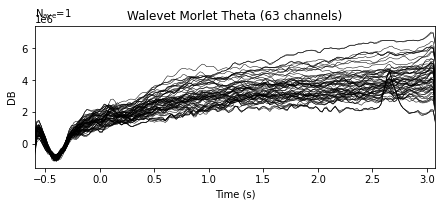

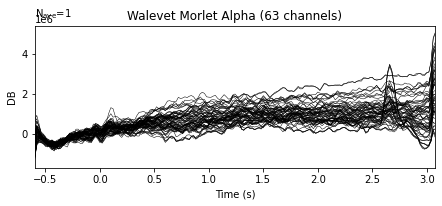

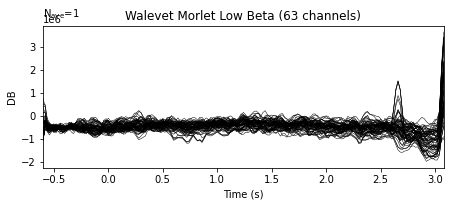

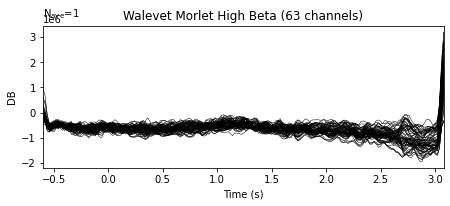

In [ ]:
trf(epochs=epochs, events=events,event_id=event_dict, path=path_raw_train, plot=True)